In [1]:
%load_ext autoreload
%autoreload 2

## Graph transformers

Graph featurizers in Molfeat are organized into pure tensor-based featurizers `dgl` backed graphs and `pyg` graphs, all inheriting from `molfeat.trans.graph.GraphTransformer`.
Similar to molecular descriptors and fingerprints, there is a notion of the **atom and bond featurizers** which you can define to build your own custom graph featurizers.
Some of the dgl featurizers are deeply integrated into the `dgl` and `dgllife` API allowing you to directly use your custom featurizers with these packages.

### AtomCalculator
Each atom featurizer takes as input an atom (assuming information on its environment is maintained) and returns its features:

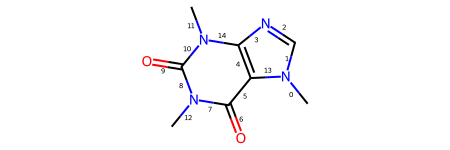

In [2]:
import datamol as dm
from rdkit.Chem.Draw import IPythonConsole

# Let's use Caffeine as a running example
smi = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
IPythonConsole.drawOptions.addBondIndices = True
mol = dm.to_mol(smi)
mol

In [3]:
from molfeat.calc.atom import AtomCalculator

ac = AtomCalculator()
ac(smi)["hv"].shape

(14, 82)

In [4]:
# To get a better sense of what's going on, you can set `concat=False`
ac = AtomCalculator(concat=False)
ac(smi).keys()

dict_keys(['atom_one_hot', 'atom_degree_one_hot', 'atom_implicit_valence_one_hot', 'atom_hybridization_one_hot', 'atom_is_aromatic', 'atom_formal_charge', 'atom_num_radical_electrons', 'atom_is_in_ring', 'atom_total_num_H_one_hot', 'atom_chiral_tag_one_hot', 'atom_is_chiral_center'])

In [5]:
ac(smi)["atom_one_hot"].shape

(14, 43)

#### Add a custom featurizer
Custom descriptors can be added by changing the passing of a dictionary of named Callables.
These are Callables that take in the atom and return a list of features.


In [6]:
def is_transition_metal(atom):
    """Check whether an atom is a transition metal"""
    n = atom.GetAtomicNum()
    return [(22 <= n <= 29) or (40 <= n <= 47) or (72 <= n <= 79)]


my_feats = {"is_transition_metal": is_transition_metal}
my_ac = AtomCalculator(featurizer_funcs=my_feats, concat=False)
my_ac(smi)

{'is_transition_metal': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)}

By default the input molecule is not ordered in any specific way, so if you want some canonical atom ranking, you would need to take care of that independently. Alternatively, you can use the `GraphTransformer` classes.

### BondCalculator

Bond featurizers are similar in principle to the atom featurizers. They featurize bonds in a molecule. In Molfeat we make the distinction between:

- `BondCalculator`: a pure bond featurizer that will only featurize bonds in the molecules (we assume a bigraph)
- `EdgeMatCalculator`: an edge featurizer that returns features between **all pairs of atoms**. For example you may want to define some distance-based properties between pairs of atoms.

In [7]:
from molfeat.calc.bond import BondCalculator

In [8]:
bc = BondCalculator()
out = bc(smi)
out["he"].shape

(30, 15)

In [9]:
# Or, again, to be more verbose:
bc = BondCalculator(concat=False)
out = bc(smi)
out.keys()

dict_keys(['bond_type_one_hot', 'bond_stereo_one_hot', 'bond_is_in_ring', 'bond_is_conjugated', 'bond_direction_one_hot'])

In [10]:
# You can also add self-loops: Edges from an atom to itself
bc = BondCalculator(self_loop=True)
out = bc(smi)
out["he"].shape

(44, 16)

### EdgeMatCalculator
In the following, we will give an overview of the **EdgeMatCalculator**. This edge featurizer defines the same bond featurizer but has an additional pairwise distance function.

**Due to its nature, all features need to be concatenated by default with this featurizer!**

In [11]:
from molfeat.calc.bond import EdgeMatCalculator

In [12]:
edge_feat = EdgeMatCalculator()
print(edge_feat.pairwise_atom_funcs)

{'pairwise_2D_dist': <function pairwise_2D_dist at 0x1704bd630>, 'pairwise_ring_membership': <function pairwise_ring_membership at 0x1704bd900>}


In [13]:
edge_feat(smi)["he"].shape

(196, 17)

Let's replace the pairwise 2D distance by a 3D distance

In [14]:
from molfeat.calc._atom_bond_features import pairwise_3D_dist

my_edge_feat = dict(
    pairwise_ring_membership=edge_feat.pairwise_atom_funcs["pairwise_ring_membership"],
    pairwise_3D_dist=pairwise_3D_dist,
)
new_edge_feat = EdgeMatCalculator(pairwise_atom_funcs=my_edge_feat)
len(new_edge_feat)

17

In [15]:
# To use the 3D distance, we need to generate 3D conformers
mol = dm.to_mol(smi)
mol = dm.conformers.generate(mol)

Let's ask for a tensor and also instead of a $({N_{atoms}}^2, Feats)$ features, let ask for a $(N_{atoms}, N_{atoms}, Feats)$ matrix


In [16]:
import torch

new_edge_feat(mol, dtype=torch.float, flat=False)["he"].shape

torch.Size([14, 14, 17])

### Putting all together
With the ability to define our own node and edge featurizers, we can define any graph featurizer of interest. Strong defaults are made available in Molfeat:

In [17]:
from molfeat.trans.graph import AdjGraphTransformer
from molfeat.trans.graph import DistGraphTransformer3D
from molfeat.trans.graph import DGLGraphTransformer
from molfeat.trans.graph import PYGGraphTransformer

In [18]:
adj_trans = AdjGraphTransformer(
    atom_featurizer=AtomCalculator(),
    bond_featurizer=EdgeMatCalculator(),
    explicit_hydrogens=True,
    self_loop=True,
    canonical_atom_order=True,
    dtype=torch.float,
)
adj_trans.atom_dim, adj_trans.bond_dim

(82, 17)

In [19]:
features = adj_trans(smi)
graph, atom_x, bond_x = features[0]
graph.shape, atom_x.shape, bond_x.shape

(torch.Size([14, 14]), torch.Size([14, 82]), torch.Size([14, 14, 17]))

In [20]:
dist_trans = DistGraphTransformer3D(
    explicit_hydrogens=False,
    canonical_atom_order=True,
    dtype=torch.float,
)

dist_trans.atom_dim, dist_trans.bond_dim

(82, 0)

In [21]:
# we don't have bond feature here
features = dist_trans(mol)
graph, atom_x = features[0]
graph.shape, atom_x.shape, bond_x.shape

(torch.Size([14, 14]), torch.Size([14, 82]), torch.Size([14, 14, 17]))

In [22]:
# we need the bond featurizer to include self_loop if the featurizer is supposed too
dgl_trans = DGLGraphTransformer(
    self_loop=True,
    bond_featurizer=BondCalculator(self_loop=True),
    canonical_atom_order=True,
    dtype=torch.float,
)

In [23]:
dgl_trans.atom_dim, dgl_trans.bond_dim

(82, 16)

In [24]:
# we don't have bond feature here
features = dgl_trans(smi)
features[0]

Graph(num_nodes=14, num_edges=44,
      ndata_schemes={'hv': Scheme(shape=(82,), dtype=torch.float32)}
      edata_schemes={'he': Scheme(shape=(16,), dtype=torch.float32)})

In [25]:
from dgllife.utils.featurizers import WeaveEdgeFeaturizer
from dgllife.utils.featurizers import WeaveAtomFeaturizer

In [26]:
# here we set complete graph to True, which requires compatibility from the atom and bond featurizer
dgl_trans = DGLGraphTransformer(
    self_loop=True,
    atom_featurizer=WeaveAtomFeaturizer(),
    bond_featurizer=WeaveEdgeFeaturizer(),
    canonical_atom_order=True,
    complete_graph=True,
    verbose=True,
    dtype=torch.float,
)

In [27]:
dgl_trans.atom_dim, dgl_trans.bond_dim

(27, 12)

In [28]:
features = dgl_trans(smi)
features[0]

Graph(num_nodes=14, num_edges=196,
      ndata_schemes={'h': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(12,), dtype=torch.float32)})

In [29]:
# You can also create a PyG graph featurizer, the same way you define a DGL graph featurizer

pyg_trans = PYGGraphTransformer(
    atom_featurizer=AtomCalculator(),
    bond_featurizer=BondCalculator(self_loop=True),
    self_loop=True,
    canonical_atom_order=True,
    dtype=torch.float,
)
pyg_trans.atom_dim, pyg_trans.bond_dim

(82, 16)

In [30]:
features = dgl_trans(smi)
features[0]

Graph(num_nodes=14, num_edges=196,
      ndata_schemes={'h': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(12,), dtype=torch.float32)})

## Tree Calculator
The tree calculator is straightforward and only a dgl datatype is supported. It's the tree decomposition behind the [Junction Tree Variational Autoencoder](http://proceedings.mlr.press/v80/jin18a/jin18a.pdf).

In [31]:
from molfeat.trans.graph import MolTreeDecompositionTransformer

In [32]:
tree_trans = MolTreeDecompositionTransformer()
tree_trans.fit([smi])

MolTreeDecompositionTransformer(featurizer=<molfeat.calc.tree.TreeDecomposer object at 0x1794cead0>,
                                n_jobs=1, verbose=False)

In [33]:
features = tree_trans(smi)
features[0]

Graph(num_nodes=7, num_edges=12,
      ndata_schemes={'hv': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})